In [388]:
# Import required libraries
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import numpy as np

# Install openpyxl if needed
try:
    import openpyxl
except ImportError:
    import subprocess
    import sys
    subprocess.check_call([sys.executable, "-m", "pip", "install", "openpyxl"])
    import openpyxl

print("Libraries imported successfully!")

# Zip Code to County: https://www.huduser.gov/apps/public/uspscrosswalk/home
# Zip Code to Geo: https://public.opendatasoft.com/explore/dataset/georef-united-states-of-america-zc-point/export/?refine.stusps_code=MN
# Poverty Metrics: https://data.census.gov/table/ACSDP5Y2023.DP03?t=Earnings+(Individuals):Income+(Households,+Families,+Individuals):Income+and+Earnings:Income+and+Poverty:SNAP/Food+Stamps&g=040XX00US27$8600000


Libraries imported successfully!


In [389]:
# Load all data files
# 1. Load the Catholic schools data
df = pd.read_csv('data/HeatMapCSV.csv')

# 2. Load the ZIP-County crosswalk data
zip_county_df = pd.read_excel('data/ZIP_COUNTY_032025.xlsx')

print("Catholic Schools Data:")
print(f"Shape: {df.shape}")
print(f"Columns: {df.columns.tolist()}")

print(f"\nZIP-County Crosswalk Data:")
print(f"Shape: {zip_county_df.shape}")
print(f"Columns: {zip_county_df.columns.tolist()}")

print("\nFirst few rows of schools data:")
df.head()


Catholic Schools Data:
Shape: (470, 8)
Columns: ['School', 'Self-Reported Gr. 8 Full Tuition 2024-25 ', 'Total Number of Scholarships 24-25', 'Total K-8 Enrollment 24-25', 'School Address', 'School City', 'State', 'Zip']

ZIP-County Crosswalk Data:
Shape: (54563, 8)
Columns: ['ZIP', 'COUNTY', 'USPS_ZIP_PREF_CITY', 'USPS_ZIP_PREF_STATE', 'RES_RATIO', 'BUS_RATIO', 'OTH_RATIO', 'TOT_RATIO']

First few rows of schools data:


,School,Self-Reported Gr. 8 Full Tuition 2024-25,Total Number of Scholarships 24-25,Total K-8 Enrollment 24-25,School Address,School City,State,Zip
0,All Saints Catholic School,"$6,100.00",18.0,411,19795 Holyoke Ave.,Lakeville,MN,55044-8816
1,Annunciation School,"$6,800.00",17.0,340,525 - 54th St. W.,Minneapolis,MN,55419-1818
2,Ascension School,"$1,400.00",72.0,272,1726 Dupont Ave. N.,Minneapolis,MN,55411-3219
3,"Ave Maria Academy (Maple Grove, MN)","$9,800.00",13.0,161,7000 Jewel Lane N.,Maple Grove,MN,55311-2504
4,Benilde-St. Margaret's Schools,"$15,625.00",8.0,194 (7-8),2501 MN-100,St Louis Park,MN,55416


In [390]:
# Clean and process the data
# Remove empty rows
df_clean = df.dropna(subset=['School', 'Zip']).copy()

# Extract 5-digit ZIP codes from ZIP+4 format (e.g., '55044-8816' -> '55044')
df_clean['zip_code'] = df_clean['Zip'].str[:5]

# Clean the tuition column (remove $ and commas)
df_clean['Tuition_Clean'] = df_clean['Self-Reported Gr. 8 Full Tuition 2024-25 '].str.replace('$', '').str.replace(',', '').astype(float)

# Clean scholarships column
df_clean['Scholarships'] = df_clean['Total Number of Scholarships 24-25']

# Parse enrollment (some have grade ranges in parentheses)
df_clean['Enrollment_Clean'] = df_clean['Total K-8 Enrollment 24-25'].astype(str).str.extract(r'(\d+)').astype(float)

# Process ZIP-County mapping
mn_zip_county = zip_county_df[zip_county_df['USPS_ZIP_PREF_STATE'] == 'MN'].copy()
mn_zip_county_best = mn_zip_county.loc[mn_zip_county.groupby('ZIP')['RES_RATIO'].idxmax()]

# Create mapping ensuring both are strings with leading zeros preserved
zip_to_county_map = dict(zip(mn_zip_county_best['ZIP'].astype(str).str.zfill(5), mn_zip_county_best['COUNTY']))

# Apply county mapping to school data
df_clean['county_fips'] = df_clean['zip_code'].map(zip_to_county_map)


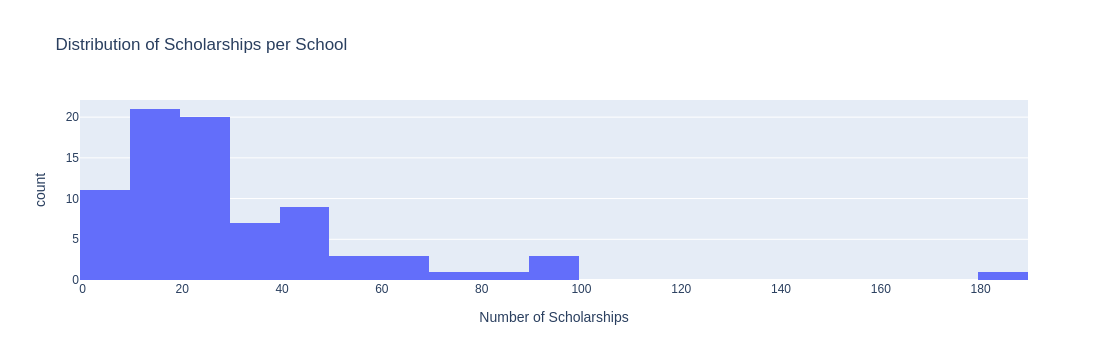

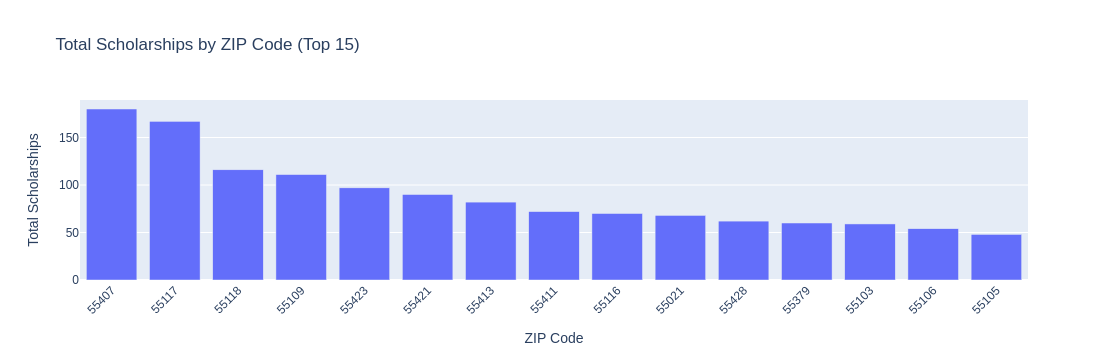

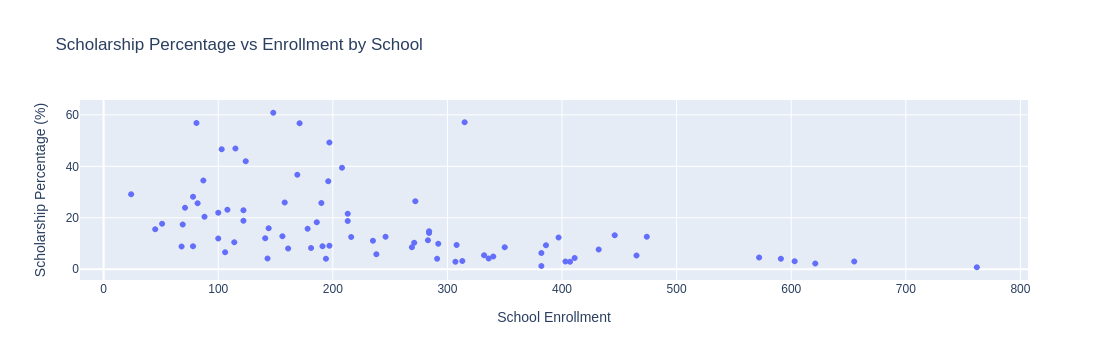

In [ ]:
# Create visualizations focused on scholarships

# 1. Scholarship distribution by school
fig1 = px.histogram(
    df_clean,
    x='Scholarships',
    nbins=20,
    title='Distribution of Scholarships per School',
    labels={'Scholarships': 'Number of Scholarships', 'count': 'Number of Schools'}
)
fig1.write_html('schol_dist_per_school.html', include_plotlyjs='inline', config={'displayModeBar': False})

fig1.show()

# 2. Top ZIP codes by total scholarships
zip_aggregated = df_clean.groupby('zip_code').agg({
    'Tuition_Clean': 'mean',
    'Scholarships': 'sum',
    'Enrollment_Clean': 'sum',
    'School': 'count'
}).reset_index()
zip_aggregated.columns = ['zip_code', 'avg_tuition', 'total_scholarships', 'total_enrollment', 'school_count']

fig2 = px.bar(
    zip_aggregated.nlargest(15, 'total_scholarships'),
    x='zip_code',
    y='total_scholarships',
    title='Total Scholarships by ZIP Code (Top 15)',
    labels={'total_scholarships': 'Total Scholarships', 'zip_code': 'ZIP Code'}
)
fig2.update_layout(xaxis_tickangle=-45)
fig2.write_html('schol_by_zip.html', include_plotlyjs='inline', config={'displayModeBar': False})

fig2.show()

# 3. Scholarship percentage vs Enrollment scatter plot
# Calculate scholarship percentage (avoid division by zero)
df_clean['scholarship_percentage'] = df_clean.apply(
    lambda row: (row['Scholarships'] / row['Enrollment_Clean'] * 100) if row['Enrollment_Clean'] > 0 else 0, 
    axis=1
)

# Calculate total financial burden: (Tuition - 1000) * Scholarships
df_clean['total_financial_burden'] = (df_clean['Tuition_Clean'] - 1000) * df_clean['Scholarships']
df_clean["School_Label"] = df_clean["School"].where(df_clean["scholarship_percentage"] >= 30, "")

fig3 = px.scatter(
    df_clean,
    x='Enrollment_Clean',
    y='scholarship_percentage',
    text='School_Label',
    hover_name='School',
    hover_data={
        'Scholarships': True,
        'Enrollment_Clean': True,
        'scholarship_percentage': ':.1f',
        'total_financial_burden': ':,.0f'
    },
    title='Scholarship Percentage vs Enrollment by School',
    labels={
        'Enrollment_Clean': 'School Enrollment',
        'scholarship_percentage': 'Scholarship Percentage (%)',
        'total_financial_burden': 'Total Financial Burden'
    }
)
fig3.update_traces(textposition='top right')
fig3.update_layout(height=800, width=1500)
fig3.write_html('schol_perc_vs_enrollment.html', include_plotlyjs='inline', config={'displayModeBar': False})

fig3.show()




In [392]:
# Process mapping results from official ZIP-County data
mapped_schools = df_clean.dropna(subset=['county_fips'])


In [ ]:
# @title
# Load comprehensive ZIP code coordinates - REQUIRED
# Load the ZIP coordinates file from Excel
zip_coords_df = pd.read_excel('data/mn_zip_cords_excel.xlsx', dtype={'Zip': str})

# Filter for Minnesota and create mapping (adjust column names as needed)
if 'State' in zip_coords_df.columns:
    mn_coords = zip_coords_df[zip_coords_df['State'] == 'MN']
else:
    mn_coords = zip_coords_df  # Assume it's already Minnesota data

# The coordinates are in the "Geo Point" column as "latitude, longitude" strings
zip_col = 'Zip Code'
geo_point_col = 'Geo Point'

# Create the coordinate mapping by parsing the Geo Point column
zip_coord_map = {}
successful_mappings = 0
failed_mappings = 0

for _, row in mn_coords.iterrows():
    zip_code = str(row[zip_col]).zfill(5)  # Ensure 5-digit ZIP code
    geo_point = row[geo_point_col]

    if pd.notna(geo_point) and isinstance(geo_point, str):
        try:
            # Split the "latitude, longitude" string
            parts = geo_point.split(',')
            if len(parts) == 2:
                lat_num = float(parts[0].strip())
                lon_num = float(parts[1].strip())
                zip_coord_map[zip_code] = (lat_num, lon_num)
                successful_mappings += 1
            else:
                failed_mappings += 1
        except (ValueError, TypeError):
            failed_mappings += 1
    else:
        failed_mappings += 1

# Apply coordinates to our data
df_clean['lat'] = df_clean['zip_code'].map(lambda x: zip_coord_map.get(x, (None, None))[0] if x in zip_coord_map else None)
df_clean['lon'] = df_clean['zip_code'].map(lambda x: zip_coord_map.get(x, (None, None))[1] if x in zip_coord_map else None)


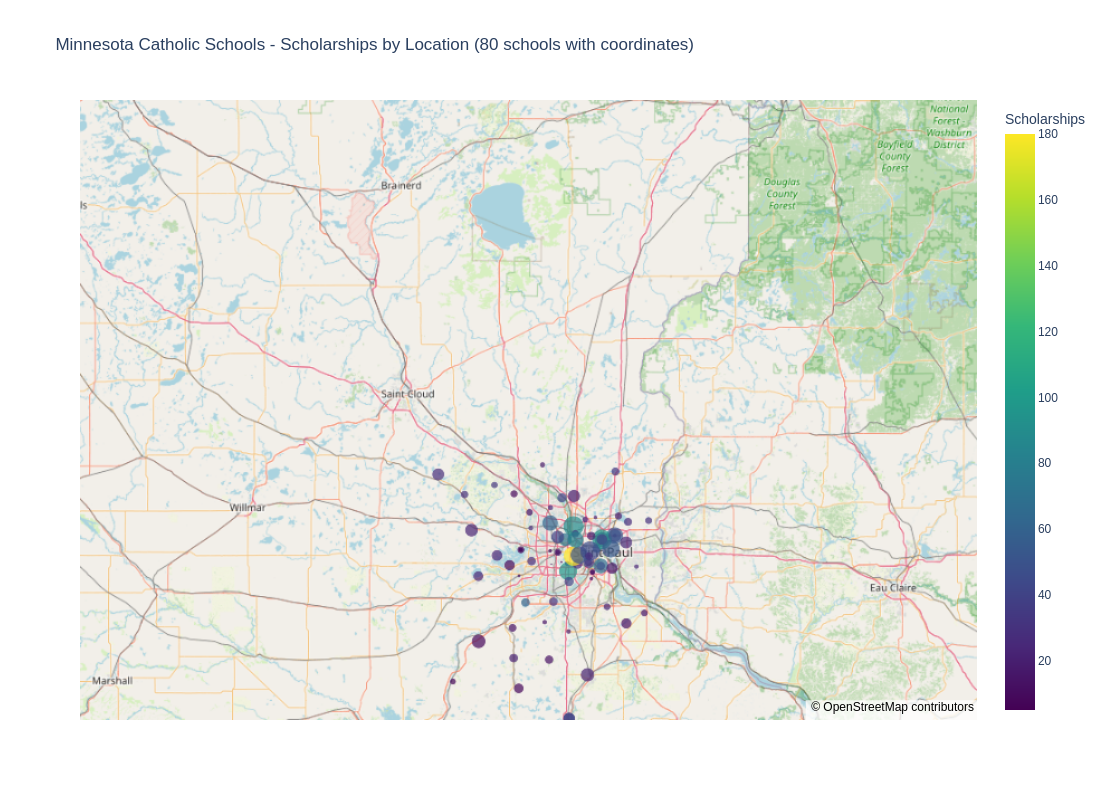

In [ ]:
# @title
# Only use schools with valid coordinates for mapping
df_with_coords = df_clean.dropna(subset=['lat', 'lon'])

# Calculate total financial burden: (Tuition - 1000) * Scholarships
df_with_coords = df_with_coords.copy()  # Avoid SettingWithCopyWarning
df_with_coords['total_financial_burden'] = (df_with_coords['Tuition_Clean'] - 1000) * df_with_coords['Scholarships']

# Create scatter map focused on scholarships (only for schools with coordinates)
if len(df_with_coords) > 0:
    fig_scatter = px.scatter_map(
        df_with_coords,
        lat='lat',
        lon='lon',
        color='Scholarships',
        size='scholarship_percentage',
        hover_name='School',
        hover_data={
            'zip_code': True,
            'Scholarships': True,
            'scholarship_percentage': ':.1f',
            'total_financial_burden': ':,.0f',
            'Tuition_Clean': ':.0f',
            'Enrollment_Clean': ':.0f',
            'School City': True
        },
        labels={
            'Tuition_Clean': 'Tuition',
            'Enrollment_Clean': 'Enrollment',
            'scholarship_percentage': 'Scholarship %',
            'total_financial_burden': 'Total Financial Burden'
        },
        color_continuous_scale="Blues",
        size_max=15,
        map_style="carto-positron",
        title=f"Minnesota Catholic Schools - Scholarships by Location ({len(df_with_coords)} schools with coordinates)",
        zoom=7,
        center={"lat": 45.5, "lon": -93.5}
    )

    fig_scatter.update_layout(height=800, width=1200)
    fig_scatter.write_html('scholarships_by_location.html', include_plotlyjs='inline', config={'displayModeBar': False})

    fig_scatter.show()


In [395]:
# Prepare data for county-level analysis
mapped_schools = df_clean.dropna(subset=['county_fips'])


In [396]:
# Create county-level aggregated data for choropleth
county_data = mapped_schools.groupby('county_fips').agg({
    'Tuition_Clean': 'mean',
    'Scholarships': 'sum', 
    'Enrollment_Clean': 'sum',
    'School': 'count'
}).reset_index()

county_data.columns = ['county_fips', 'avg_tuition', 'total_scholarships', 'total_enrollment', 'school_count']


In [ ]:
# @title
# Extract poverty data from Minnesota Income Excel file
# Load the raw Excel data from the 'Data' sheet
import re

print("Extracting poverty data from Minnesota Income Excel file...")

# Load the data from the 'Data' sheet (not the 'Information' sheet)
income_df_raw = pd.read_excel('data/Minnesota_Income_Zip_Code.xlsx', sheet_name='Data', header=None)
print(f"Raw data shape: {income_df_raw.shape}")

# Step 1: Identify the header row and data structure
# Look for ZIP codes in the first few rows (likely the header)
zip_header_row = None
zip_columns = []

for row_idx in range(min(5, income_df_raw.shape[0])):  # Check first 5 rows
    row_data = income_df_raw.iloc[row_idx, :]
    zip_count = 0
    temp_zip_cols = []

    for col_idx, cell_value in enumerate(row_data):
        if pd.notna(cell_value):
            cell_str = str(cell_value)
            # Look for ZCTA5 format or 5-digit ZIP codes
            if 'ZCTA5' in cell_str or re.search(r'\b\d{5}\b', cell_str):
                zip_count += 1
                # Extract the ZIP code from ZCTA5 format or direct 5-digit
                if 'ZCTA5' in cell_str:
                    zip_match = re.search(r'ZCTA5\s+(\d{5})', cell_str)
                else:
                    zip_match = re.search(r'\b(\d{5})\b', cell_str)
                if zip_match:
                    temp_zip_cols.append((col_idx, zip_match.group(1)))

    if zip_count > 10:  # If we found many ZIP codes, this is likely the header row
        zip_header_row = row_idx
        zip_columns = temp_zip_cols
        print(f"Found ZIP code header at row {row_idx} with {len(zip_columns)} ZIP codes")
        break

if zip_header_row is not None:
    print(f"Sample ZIP codes found: {[zc[1] for zc in zip_columns[:10]]}")

    # Step 2: Find the poverty percentage row and mean income row
    poverty_row = None
    income_row = None

    for row_idx in range(zip_header_row + 1, income_df_raw.shape[0]):
        row_label = income_df_raw.iloc[row_idx, 0]
        if pd.notna(row_label):
            label_str = str(row_label).lower()
            # Look specifically for "all people" row (not just any poverty-related keyword)
            if 'all people' in label_str and poverty_row is None:
                poverty_row = row_idx
                print(f"Found poverty row at index {row_idx}: {row_label}")
            # Look for mean household income row
            elif 'mean household income' in label_str and income_row is None:
                income_row = row_idx
                print(f"Found income row at index {row_idx}: {row_label}")

        # Stop if we found both rows
        if poverty_row is not None and income_row is not None:
            break

    if poverty_row is not None and income_row is not None:
        # Step 3: Extract both poverty and income data
        # The poverty percentages are in the "Percent" column (offset +2 from ZIP code column)
        # The mean income is in the "Estimate" column (offset +0 from ZIP code column)
        poverty_data = []

        for col_idx, zip_code in zip_columns:
            # Get poverty percentage (offset +2)
            percent_col_idx = col_idx + 2
            # Get mean income (offset +0)
            income_col_idx = col_idx + 0

            poverty_value = None
            income_value = None

            # Extract poverty percentage
            if percent_col_idx < income_df_raw.shape[1]:
                poverty_raw = income_df_raw.iloc[poverty_row, percent_col_idx]

                if pd.notna(poverty_raw):
                    try:
                        # Handle percentage strings like "6.9%"
                        if isinstance(poverty_raw, str):
                            # Remove % sign and convert to float
                            poverty_str = poverty_raw.replace('%', '').strip()
                            poverty_value = float(poverty_str)
                        else:
                            poverty_value = float(poverty_raw)

                        # Only accept reasonable poverty rates (0-100%)
                        if not (0 <= poverty_value <= 100):
                            poverty_value = None
                    except (ValueError, TypeError):
                        poverty_value = None

            # Extract mean income
            if income_col_idx < income_df_raw.shape[1]:
                income_raw = income_df_raw.iloc[income_row, income_col_idx]

                if pd.notna(income_raw):
                    try:
                        # Handle income strings with commas like "45,678" or just numbers
                        if isinstance(income_raw, str):
                            # Remove commas and dollar signs, then convert to float
                            income_str = income_raw.replace(',', '').replace('$', '').strip()
                            income_value = float(income_str)
                        else:
                            income_value = float(income_raw)

                        # Only accept reasonable income values (> 0 and < 1,000,000)
                        if not (0 < income_value < 1000000):
                            income_value = None
                    except (ValueError, TypeError):
                        income_value = None

            # Add to data if we have at least poverty data
            if poverty_value is not None:
                poverty_data.append({
                    'zip_code': str(zip_code).zfill(5),
                    'poverty_rate': poverty_value,
                    'mean_income': income_value  # Will be None if not available
                })

        # Step 4: Create the clean DataFrame
        if poverty_data:
            poverty_df = pd.DataFrame(poverty_data)
            print(f"\nSuccessfully extracted data for {len(poverty_df)} ZIP codes")
            print(f"Poverty rate range: {poverty_df['poverty_rate'].min():.1f}% to {poverty_df['poverty_rate'].max():.1f}%")
            print(f"Average poverty rate: {poverty_df['poverty_rate'].mean():.1f}%")

            # Check income data coverage
            income_count = poverty_df['mean_income'].notna().sum()
            if income_count > 0:
                print(f"Mean income data available for {income_count} ZIP codes")
                print(f"Income range: ${poverty_df['mean_income'].min():,.0f} to ${poverty_df['mean_income'].max():,.0f}")
                print(f"Average income: ${poverty_df['mean_income'].mean():,.0f}")
            else:
                print("No income data was successfully extracted")

            # Save to CSV for future use
            output_file = 'data/mn_zip_poverty_rates.csv'
            poverty_df.to_csv(output_file, index=False)
            print(f"\nSaved clean poverty and income data to: {output_file}")

            # Display sample data
            print("\nSample of extracted data:")
            print(poverty_df.head(10))

        else:
            print("ERROR: No valid poverty data could be extracted")
            poverty_df = pd.DataFrame()
    else:
        print("ERROR: Could not find both poverty and income rows")
        poverty_df = pd.DataFrame()
else:
    print("ERROR: Could not find ZIP code header row")
    poverty_df = pd.DataFrame()


Extracting poverty data from Minnesota Income Excel file...
Raw data shape: (147, 3549)
Found ZIP code header at row 0 with 887 ZIP codes
Sample ZIP codes found: ['51360', '55001', '55003', '55005', '55006', '55007', '55008', '55009', '55011', '55012']
Found income row at index 70: Mean household income (dollars)
Found poverty row at index 137: All people

Successfully extracted data for 880 ZIP codes
Poverty rate range: 0.0% to 100.0%
Average poverty rate: 10.0%
Mean income data available for 874 ZIP codes
Income range: $38,979 to $340,154
Average income: $99,505

Saved clean poverty and income data to: data/mn_zip_poverty_rates.csv

Sample of extracted data:
  zip_code  poverty_rate  mean_income
0    51360           6.9      95506.0
1    55001           5.7     179832.0
2    55003           3.9     121788.0
3    55005           2.1     120306.0
4    55006          12.4      80764.0
5    55007           8.9      79707.0
6    55008           9.3      93809.0
7    55009           5.7   

In [ ]:
# Load the clean poverty data (created in previous cell or from saved file)
# Try to use the clean data we just created, or load from saved file
if 'poverty_df' in locals() and len(poverty_df) > 0:
    print("Using poverty data from previous cell processing")
else:
    # Try to load from saved CSV file
    try:
        poverty_df = pd.read_csv('data/mn_zip_poverty_rates.csv', dtype={'zip_code': str})
        print(f"Loaded poverty data from saved CSV file: {len(poverty_df)} ZIP codes")
    except FileNotFoundError:
        print("ERROR: No clean poverty data available. Please run the previous cell successfully first.")
        poverty_df = pd.DataFrame()

if len(poverty_df) > 0:
    print(f"\nClean poverty data summary:")
    print(f"ZIP codes: {len(poverty_df)}")
    print(f"Poverty rate range: {poverty_df['poverty_rate'].min():.1f}% to {poverty_df['poverty_rate'].max():.1f}%")
    print(f"Average poverty rate: {poverty_df['poverty_rate'].mean():.1f}%")
    print("\nSample data:")
    print(poverty_df.head())


Using poverty data from previous cell processing

Clean poverty data summary:
ZIP codes: 880
Poverty rate range: 0.0% to 100.0%
Average poverty rate: 10.0%

Sample data:
  zip_code  poverty_rate  mean_income
0    51360           6.9      95506.0
1    55001           5.7     179832.0
2    55003           3.9     121788.0
3    55005           2.1     120306.0
4    55006          12.4      80764.0


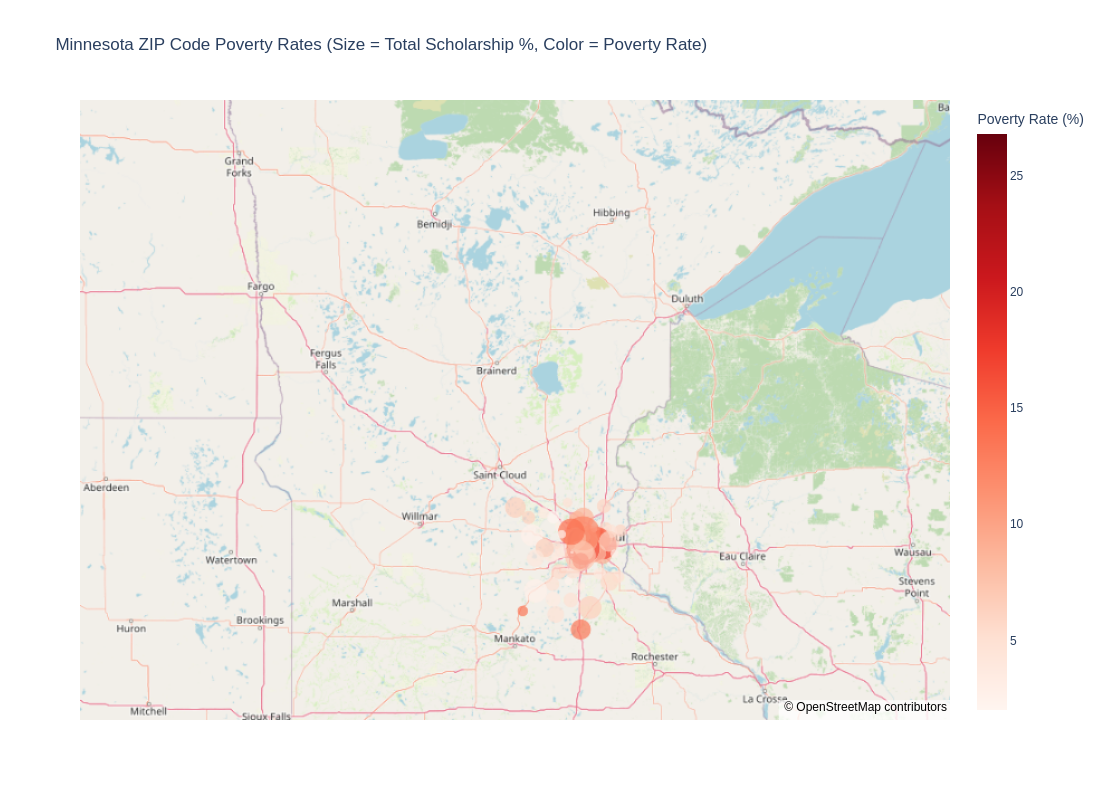

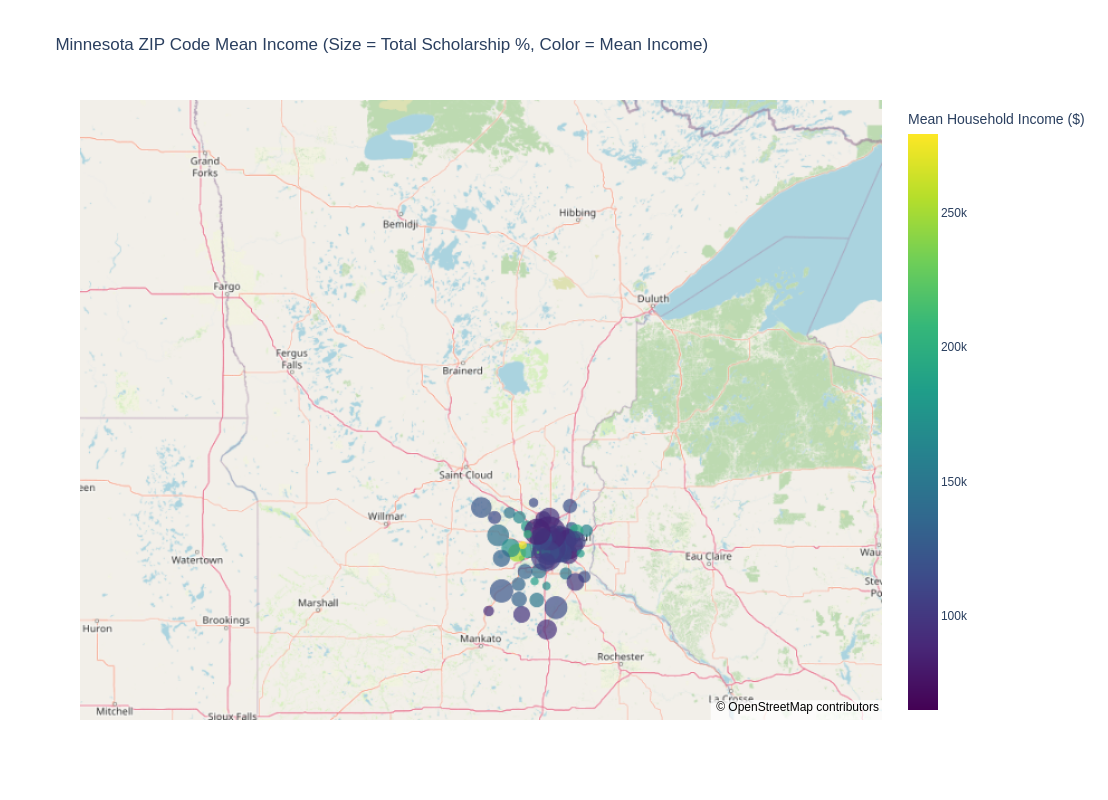

In [ ]:
# @title
# Create ZIP code poverty rate choropleth map
# Note: For ZIP code level maps, we need ZIP boundary data
# We'll use a scatter plot with ZIP coordinates and poverty rates as an alternative

# Check if poverty data is available and has the required columns
if 'poverty_df' in locals() and len(poverty_df) > 0 and 'zip_code' in poverty_df.columns and 'poverty_rate' in poverty_df.columns:

    # Aggregate school data by ZIP code to get scholarship information
    zip_school_data = df_clean.groupby('zip_code').agg({
        'Scholarships': 'sum',  # Total scholarships per ZIP
        'Enrollment_Clean': 'sum',  # Total enrollment per ZIP
        'School': lambda x: ', '.join(x),  # Join all school names with commas
        'lat': 'first',  # Take first coordinate (they should be the same for same ZIP)
        'lon': 'first'
    }).reset_index()

    # Calculate total scholarship percentage per ZIP code
    zip_school_data['total_scholarship_percentage'] = (
        zip_school_data['Scholarships'] / zip_school_data['Enrollment_Clean'] * 100
    ).fillna(0)  # Handle any division by zero

    # Merge poverty data with school and coordinate data
    poverty_with_coords = poverty_df.merge(
        zip_school_data,
        on='zip_code',
        how='inner'
    )



    if len(poverty_with_coords) > 0:
        # Create scatter map showing poverty rates by ZIP code with total scholarship percentage as size
        fig_poverty = px.scatter_map(
            poverty_with_coords,
            lat='lat',
            lon='lon',
            color='poverty_rate',
            size='total_scholarship_percentage',
            hover_data={
                'zip_code': True,
                'poverty_rate': ':.1f',
                'total_scholarship_percentage': ':.1f',
                'Scholarships': True,
                'Enrollment_Clean': True,
                'School': True
            },
            color_continuous_scale='Blues',
            size_max=25,
            map_style='carto-positron',
            title='Minnesota ZIP Code Poverty Rates (Size = Total Scholarship %, Color = Poverty Rate)',
            labels={
                'poverty_rate': 'Poverty Rate (%)',
                'total_scholarship_percentage': 'Total Scholarship Percentage (%)'
            },
            zoom=6,
            center={"lat": 46.0, "lon": -94.0}
        )

        fig_poverty.update_layout(height=800, width=1200)
        fig_poverty.write_html('zip_copde_pov_rates.html', include_plotlyjs='inline', config={'displayModeBar': False})

        fig_poverty.show()

        # Create second scatter map showing mean income by color and scholarship percentage by size
        if 'mean_income' in poverty_with_coords.columns:
            # Filter out ZIP codes with no income data for this map
            income_with_coords = poverty_with_coords.dropna(subset=['mean_income'])

            if len(income_with_coords) > 0:
                fig_income = px.scatter_map(
                    income_with_coords,
                    lat='lat',
                    lon='lon',
                    color='mean_income',
                    size='total_scholarship_percentage',
                    hover_data={
                        'zip_code': True,
                        'mean_income': ':,.0f',
                        'poverty_rate': ':.1f',
                        'total_scholarship_percentage': ':.1f',
                        'Scholarships': True,
                        'Enrollment_Clean': True,
                        'School': True
                    },
                    color_continuous_scale='Blues',
                    size_max=25,
                    map_style='carto-positron',
                    title='Minnesota ZIP Code Mean Income (Size = Total Scholarship %, Color = Mean Income)',
                    labels={
                        'mean_income': 'Mean Household Income ($)',
                        'total_scholarship_percentage': 'Total Scholarship Percentage (%)'
                    },
                    zoom=6,
                    center={"lat": 46.0, "lon": -94.0}
                )

                fig_income.update_layout(height=800, width=1200)
                fig_income.write_html('zip_code_mean_income.html', include_plotlyjs='inline', config={'displayModeBar': False})
                fig_income.show()





In [ ]:
# @title
# Analyze relationship between poverty rates and school scholarships
# Check if poverty data is available before attempting merge
if 'poverty_df' in locals() and len(poverty_df) > 0 and 'zip_code' in poverty_df.columns and 'poverty_rate' in poverty_df.columns:

    # Merge school data with poverty data
    schools_with_poverty = df_clean.merge(
        poverty_df,
        on='zip_code',
        how='left'
    )

    schools_with_poverty_data = schools_with_poverty.dropna(subset=['poverty_rate'])

    if len(schools_with_poverty_data) > 0:

         # Scatter plot: Poverty rate vs Scholarship percentage
        fig_poverty_burden = px.scatter(
            schools_with_poverty_data,
            x='total_financial_burden',
            y='poverty_rate',
            hover_name='School',
            hover_data={
                'zip_code': True,
                'Scholarships': True,
                'Enrollment_Clean': True,
                'total_financial_burden': ':,.0f'
            },
            title='School Scholarship Percentage vs Area Poverty Rate',
            labels={
                'poverty_rate': 'ZIP Code Poverty Rate (%)',
                'total_financial_burden': 'Financial Burden',
                'Enrollment_Clean': "Enrollment",
                "zip_code": "Zip Code"
            }
        )

        fig_poverty_burden.write_html('schol_perc_vs_pov_rate.html', 
                             include_plotlyjs='inline',
                             config={'displayModeBar': False})


        fig_poverty_burden.show()


